<a href="https://colab.research.google.com/github/o54ma-4l5h4r1f/ChessObjectsDetection/blob/main/ChessObjectsTrainingAndDetection-YOLOv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

# Let's Start Training 

## Configuring cuDNN on Colab for YOLOv4


In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version

# Colab added cuDNN as an inherent install - so you don't have to do a thing - major win
!nvidia-smi

# This code ensures you have the correct architecture for your respective GPU
# If you command is not found, look through these GPUs, find the respective
# GPU and add them to the archTypes dictionary

import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

## Installing Darknet for YOLOv4 on Colab

In [ ]:
%cd /content/
%rm -rf darknet
!git clone https://github.com/roboflow-ai/darknet.git
%cd /content/darknet/

#colab occasionally shifts dependencies around, at the time of authorship, This Makefile works for building Darknet on Colab
%rm Makefile
!wget https://raw.githubusercontent.com/o54ma-4l5h4r1f/ChessObjectsDetection/Yolov4/Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_37,code=sm_37/ARCH= ${ARCH_VALUE}/g" Makefile

In [ ]:
!make

## Installing Yolov4 ConvNet weights

In [ ]:
#download the newly released yolov4 ConvNet weights
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

## Set up Custom Dataset for YOLOv4

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="darknet", notebook="roboflow-yolov4")

%cd /content/

rf = Roboflow(api_key="zULeeVmmrvMu6rp8LSoQ")
project = rf.workspace("osama-alsharif").project("chessobjectsdetection-ggjgw")
dataset = project.version(1).download("darknet")

##===================================================================================================

#Set up training file directories for custom dataset
%cd /content/darknet/
%cp {dataset.location}/train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp {dataset.location}/train/*.jpg data/obj/
%cp {dataset.location}/valid/*.jpg data/obj/

%cp {dataset.location}/train/*.txt data/obj/
%cp {dataset.location}/valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 5\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

## Write Custom Training Config for YOLOv4

In [ ]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len(dataset.location + '/train/_darknet.labels')
print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-detector.cfg'): os.remove('./cfg/custom-yolov4-detector.cfg')


with open('./cfg/custom-yolov4-detector.cfg', 'a') as f:
  f.write('[net]' + '\n')
  f.write('batch=64' + '\n')
  #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
  f.write('subdivisions=24' + '\n')
  f.write('width=416' + '\n')
  f.write('height=416' + '\n')
  f.write('channels=3' + '\n')
  f.write('momentum=0.949' + '\n')
  f.write('decay=0.0005' + '\n')
  f.write('angle=0' + '\n')
  f.write('saturation = 1.5' + '\n')
  f.write('exposure = 1.5' + '\n')
  f.write('hue = .1' + '\n')
  f.write('\n')
  f.write('learning_rate=0.001' + '\n')
  f.write('burn_in=1000' + '\n')
  ######you can adjust up and down to change training time#####
  ##Darknet does iterations with batches, not epochs####
  # max_batches = num_classes*2000
  max_batches = 500
  f.write('max_batches=' + str(max_batches) + '\n')
  f.write('policy=steps' + '\n')
  steps1 = .8 * max_batches
  steps2 = .9 * max_batches
  f.write('steps='+str(steps1)+','+str(steps2) + '\n')

#Instructions from the darknet repo
#change line classes=80 to your number of objects in each of 3 [yolo]-layers:
#change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

  with open('cfg/yolov4-custom2.cfg', 'r') as f2:
    content = f2.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 0,1,2' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom3.cfg', 'r') as f3:
    content = f3.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 3,4,5' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom4.cfg', 'r') as f4:
    content = f4.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 6,7,8' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('cfg/yolov4-custom5.cfg', 'r') as f5:
    content = f5.readlines()
    for line in content:
      f.write(line)

print("file is written!")

In [ ]:
#here is the file that was just written. 
#you may consider adjusting certain things

#like the number of subdivisions 64 runs faster but Colab GPU may not be big enough
#if Colab GPU memory is too small, you will need to adjust subdivisions to 16
from google.colab import files
files.download('/content/darknet/cfg/custom-yolov4-detector.cfg')
files.download('/content/darknet/data/valid.txt')
files.download('/content/darknet/data/train.txt')
files.download('/content/darknet/data/obj.data')
files.download('/content/darknet/data/obj.names')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Train Custom YOLOv4 Detector

In [ ]:
!./darknet detector train data/obj.data cfg/custom-yolov4-detector.cfg yolov4.conv.137 -dont_show -map
files.download('/content/darknet/backup/custom-yolov4-detector_best.weights')

## Testing our training result

In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

In [ ]:
#coco.names is hardcoded somewhere in the detector
%cd /content/darknet/
%cp data/obj.names data/coco.names

/content/darknet


In [ ]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('/content/ChessObjectsDetection-1/test') if f.endswith('.jpg')]
import random
img_path = "/content/ChessObjectsDetection-1/test" + random.choice(test_images);

#test out our detector!
!./darknet detect /content/tmp/custom-yolov4-detector.cfg /content/tmp/custom-yolov4-detector_best.weights {img_path} -dont-show
imShow('/content/darknet/predictions.jpg')

----- 
<br><br><br><br><br><br><br><br>

-----

# Real Time Object Detection 

## import dependencies

In [1]:

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# take the needed file from the training
%cd /content/
# !git clone https://github.com/o54ma-4l5h4r1f/tmp.git
from google.colab import drive
drive.mount('/content/drive')

## Cloning and Setting Up Darknet for YOLOv4


In [ ]:
# clone darknet repo
%cd /content/
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

In [6]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [ ]:
!pip install chess
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="darknet", notebook="roboflow-yolov4")

%cd /content/

rf = Roboflow(api_key="zULeeVmmrvMu6rp8LSoQ")
project = rf.workspace("osama-alsharif").project("chessobjectsdetection-ggjgw")
dataset = project.version(1).download("darknet")

In [ ]:
#Set up training file directories for custom dataset
%cd /content/darknet/
%cp {dataset.location}/train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp {dataset.location}/train/*.jpg data/obj/
%cp {dataset.location}/valid/*.jpg data/obj/

%cp {dataset.location}/train/*.txt data/obj/
%cp {dataset.location}/valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 5\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation.

In [ ]:
%cd /content/darknet
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("/content/drive/MyDrive/DetectionData/custom-yolov4-detector.cfg", "/content/drive/MyDrive/DetectionData/obj.data", "/content/drive/MyDrive/DetectionData/custom-yolov4-detector_best.weights")
width = network_width(network)
height = network_height(network)

In [10]:
print(width, height)

416 416


In [11]:
# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

### YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

In [12]:
def Detect2(image, detections, width_ratio, height_ratio):
  for label, confidence, bbox in detections:
    x, y, w, h = bbox2points(bbox)
    x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)
    # x, y, w, h = coordinates

    cv2.rectangle(image, (x, y), (w, h), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,class_colors[label], 1)
      
  cv2_imshow(image)

/content/ChessObjectsDetection-1/test/12_jpg.rf.5740defaf05725edd358953ec9fedce3.jpg


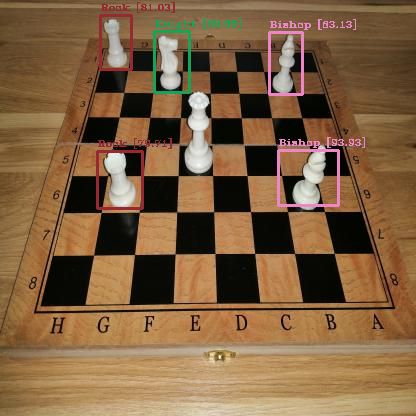

/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg


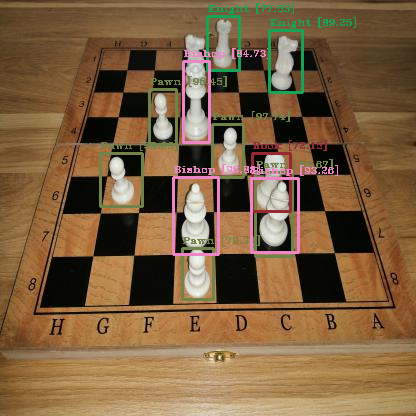

/content/ChessObjectsDetection-1/test/5_jpg.rf.18dd75b4224e0c5d5593cbcd9995408d.jpg


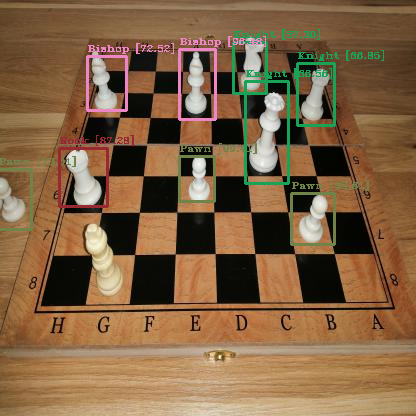

/content/ChessObjectsDetection-1/test/19_jpg.rf.bbccbf65104cf6229b9acbc826788bb2.jpg


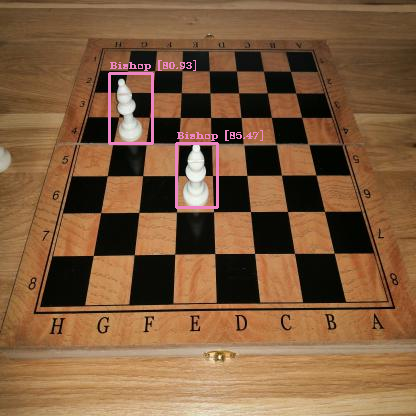

In [13]:
# run test on person.jpg image that comes with repository
folder = '/content/ChessObjectsDetection-1/test/'

for I in os.listdir(folder):
  if I.endswith('.jpg'):
    print(folder + I) 

    image = cv2.imread(folder + I)
    detections, width_ratio, height_ratio = darknet_helper(image, width, height)
    Detect2(image, detections, width_ratio, height_ratio)
  

### Non maximum suppression

In [14]:
import torch
from torchvision.ops import nms

In [36]:
def NMS(image, detections, width_ratio, height_ratio, draw=0):
  B = []
  S = []
  L = []
  for label, confidence, bbox in detections:
    x, y, w, h = bbox2points(bbox)
    x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)
    B.append([x, y, w, h])
    S.append(float(confidence))
    L.append(label)

  boxes = torch.tensor(B, dtype=torch.float32)
  scores = torch.tensor(S, dtype=torch.float32)
  N = nms(boxes = boxes, scores = scores, iou_threshold=0.3) # 0.2

  if draw:
    for i in N: 
      x, y, w, h = B[i]
      confidence = S[i]
      label = L[i]

      cv2.rectangle(image, (x, y), (w, h), class_colors[label], 2)
      cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,class_colors[label], 1)

  return image, N, B, S, L

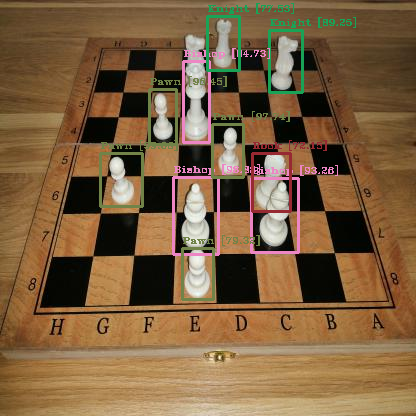

In [16]:
I = '/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg'

image = cv2.imread(I)

detections, width_ratio, height_ratio = darknet_helper(image, width, height)

image, N, B, S, L = NMS(image, detections, width_ratio, height_ratio, flag=1)
      
cv2_imshow(image)


### Grid Design

#### Stage 1 : Detect Board corners manually 


In [17]:
def DetectBorder(image, H1=(114,59), A1=(301,59), A8=(359,277), H8=(66,280)):
  # H1 = (114,59)
  # A1 = (301,59)
  # A8 = (359,277)
  # H8 = (66,280)

  MHL1 = [H1, A1]
  MHL2 = [H8, A8]
  MVL1 = [H1, H8]
  MVL2 = [A1, A8]

  image = cv2.line(image, MHL1[0], MHL1[1], (100, 0, 255), thickness=2)
  image = cv2.line(image, MHL2[0], MHL2[1], (100, 0, 255), thickness=2)
  image = cv2.line(image, MVL1[0], MVL1[1], (100, 0, 255), thickness=2)
  image = cv2.line(image, MVL2[0], MVL2[1], (100, 0, 255), thickness=2)

  return image, MHL1, MHL2, MVL1, MVL2

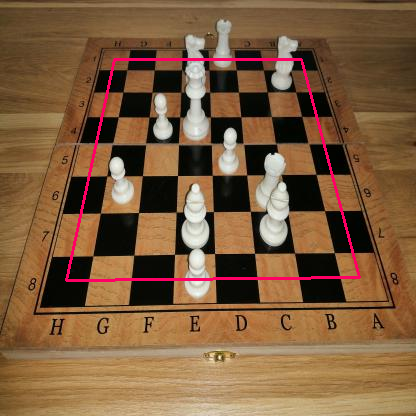

In [18]:
image, MHL1, MHL2, MVL1, MVL2 = DetectBorder(cv2.imread(I))

cv2_imshow(image)

#### Stage 2 : Draw the Grid

In [19]:
'''
split the  MHLs into 8 equal lines
'''
def DrawTheGrid(image, MHL1, MHL2, MVL1, MVL2):

  # Space between each adjacant lines
  Spaces = round((abs(MHL1[0][0] - MHL1[1][0]))/7)
  MHL1Points = []
  for i in range(0,8):
    MHL1Points.append((MHL1[0][0] + Spaces*i, MHL1[0][1]))

  # print(MHL1Points)

  Spaces = round((abs(MHL2[0][0] - MHL2[1][0]))/7)
  MHL2Points = []
  for i in range(0,8):
    MHL2Points.append((MHL2[0][0] + Spaces*i, MHL2[0][1]))  

  # print(MHL2Points)

  # connects points between the main horizontal lines
  VL = []
  for i in range(len(MHL1Points)):
    cv2.line(image, MHL1Points[i], MHL2Points[i], (255, 0, 100), thickness=1)
    VL.append([MHL1Points[i], MHL2Points[i]])

  # cv2_imshow(image)


  '''
  split the  MVLs into 8 equal lines
  '''
  Ratios = [0, 0.7, 0.7, 0.75, 0.8, 0.85, 0.9, 1]
  # Space between each adjacant lines 
  # Notice the lines are not perfectly vertical 
  SpacesX = round((abs(MVL1[0][0] - MVL1[1][0]))/7); # print(SpacesX)
  SpacesY = round((abs(MVL1[0][1] - MVL1[1][1]))/7); # print(SpacesY)
  MVL1Points = []
  for i in range(0,8):
    # print(round(SpacesX*Ratios[i]))
    MVL1Points.append((MVL1[0][0] - round(SpacesX*i*Ratios[i]), MVL1[0][1] + round(SpacesY*i*Ratios[i])))

  # print(MVL1Points)

  SpacesX = round((abs(MVL2[0][0] - MVL2[1][0]))/7); # print(SpacesX)
  SpacesY = round((abs(MVL2[0][1] - MVL2[1][1]))/7); # print(SpacesY)
  MVL2Points = []

  for i in range(0,8):
    MVL2Points.append((MVL2[0][0] + round(SpacesX*i*Ratios[i]), MVL2[0][1] + round(SpacesY*i*Ratios[i])))

  # print(MVL2Points)


  # connects points between the main vertical lines
  HL = []
  for i in range(len(MVL1Points)):
    cv2.line(image, MVL1Points[i], MVL2Points[i], (255, 0, 100), thickness=1)
    HL.append([MVL1Points[i], MVL2Points[i]])

  return image, HL, VL

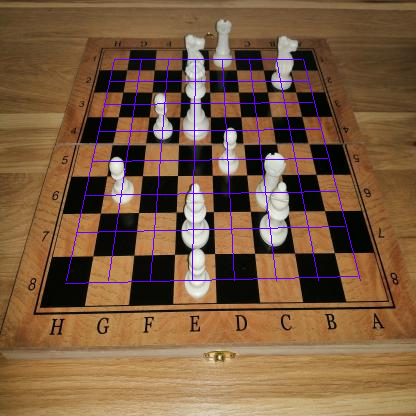

In [20]:
image = cv2.imread(I)

image, HL, VL = DrawTheGrid(image, MHL1, MHL2, MVL1, MVL2)

cv2_imshow(image)

#### Stage 3 : Get The Intersection Points

In [21]:
from numpy import *

def perp( a ) :
  b = empty_like(a)
  b[0] = -a[1]
  b[1] = a[0]
  return b

def seg_intersect(a1,a2, b1,b2) :
  da = a2-a1
  db = b2-b1
  dp = a1-b1
  dap = perp(da)
  denom = dot( dap, db)
  num = dot( dap, dp )
  # print(((num / denom.astype(int))*db + b1)[0])
  try:
    IntersectionPoint = (int(((num / denom.astype(int))*db + b1)[0]), int(((num / denom.astype(int))*db + b1)[1]))
    return IntersectionPoint
  except:
    return None

## ==========================================================================================

def GetIntersectionPoints(image, HL, VL):
  IntersectionPoints = []
  i = 0
  for L1 in HL:  # L1 = [(114, 59), (301, 59)]
    for L2 in VL:  # L2 = [(114, 59), (66, 280)]
      P = seg_intersect(array(L1[0]),array(L1[1]),array(L2[0]),array(L2[1]))
      if P != None:
        # print(P)
        IntersectionPoints.append(P)
        cv2.circle(image, P, 9, (255,0,255), thickness=cv2.FILLED)
        cv2.putText(image, "{}".format(i),(P[0]-6,P[1]+3), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,(0,215,255), 1)
        i += 1

  return image, IntersectionPoints

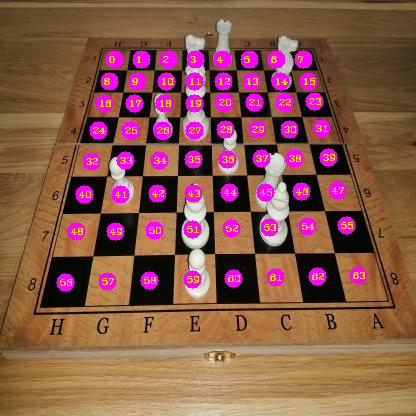

In [22]:
image, IntersectionPoints =  GetIntersectionPoints(cv2.imread(I), HL, VL)

cv2_imshow(image)

#### Stage 4 : Detecting and positioning

In [23]:
def Detect(image, detections, width_ratio, height_ratio, IntersectionPoints):
  
  ObjsLocation = {}

  image, N, B, S, L = NMS(image, detections, width_ratio, height_ratio, draw=0)

  for i in N: 
    x, y, w, h = B[i]  # w = x + actual width 
    confidence = S[i]
    label = L[i]

    W = w - x
    H = h - y 

    cv2.rectangle(image, (x, y), (w, h), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,class_colors[label], 1)

    j = 0
    for x1, y1 in IntersectionPoints:
      if (x < x1 and x1 < x+W) and (y+round(H/1.8) < y1 and y1 < y+H):
        cv2.putText(image, "{}".format(j),(x1-6,y1+3), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,(0,0,0), 1)
        # print(x1, y1)
        ObjsLocation[j] = label
      j += 1 

  print(ObjsLocation)
  return image, ObjsLocation

 

{41: 'Pawn', 51: 'Bishop', 36: 'Pawn', 26: 'Pawn', 53: 'Bishop', 14: 'Knight', 27: 'Bishop', 59: 'Pawn', 4: 'Knight', 45: 'Rook'}


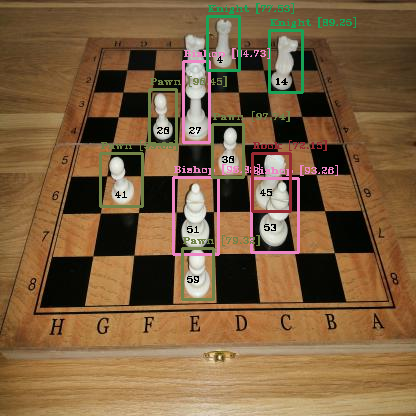

In [24]:
image = cv2.imread(I)

detections, width_ratio, height_ratio = darknet_helper(image, width, height)

image, ObjsLocation = Detect(image, detections, width_ratio, height_ratio, IntersectionPoints)

cv2_imshow(image)

#### Stage 5 : Vertical Projection 

In [25]:
import chess 

ObjsNames = {
  'Bishop': 'B',
  'Knight': 'N',
  'Pawn': 'P',
  'Queen': 'Q',
  'Rook': 'R'
} 

def GameView(ObjsLocation):
  Chess = ""
  for i in range(0, 64):
    if i != 0 and i % 8 == 0:
      Chess += '/'

    if i in ObjsLocation.keys():
      Chess += ObjsNames[ObjsLocation[i]]
    else:
      Chess += '1'

  for i in range(8, 0, -1):
    Chess = Chess.replace('1'*i, str(i))

  print(Chess)  

  # board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR") # b KQkq - 0 4
  return chess.Board(Chess)

4N3/6N1/8/2PB4/4P3/1P3R2/3B1B2/3P4


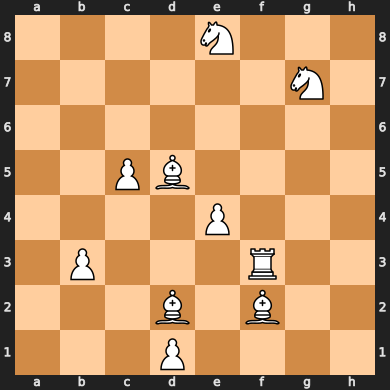

In [26]:
board = GameView(ObjsLocation)
board

# Real Time Objects Detection


### Helper Functions

In [30]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images


In [27]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## YOLOv4 on Webcam Videos

### JavaScript to properly create our live video stream using our webcam as input

In [31]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    # create transparent overlay for bounding box
    image = np.zeros([480,640,4], dtype=np.uint8)

    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
    # If we detect something
    if detections != []:
      image = NMS(image, detections, width_ratio, height_ratio, draw=1)[0]


    '''
    Show Frame
    '''

    image[:,:,3] = (image.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(image)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

## Have a great day!